In [1]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Lunar Rock/')

Mounted at /content/gdrive


In [0]:
# !wget http://hck.re/kkBIfM
# !unzip kkBIfM
# !unzip "DataSet/Train Images.zip"
!unzip "DataSet/Test Images.zip"

In [2]:
import shutil
import random
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import glob
from tqdm import tqdm

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from keras.models import Model,load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
train = pd.read_csv('train.csv')
print(train.shape)
train.head()

(11998, 2)


,Image_File,Class
0,clean2416.png,Large
1,ground4022.png,Small
2,ground0340.png,Small
3,ground2110.png,Small
4,clean1581.png,Large


In [6]:
valid_samples = train.sample(frac=0.3, random_state=42)
print(valid_samples.shape)

(3599, 2)


In [22]:
%%time

src = 'Train Images'
dest = 'Validation Images'
for _,row in valid_samples.iterrows():
    file = row['Image_File']
    loc = row['Class']
    shutil.move(f'{src}/{loc}/{file}', f'{dest}/{loc}/{file}')
    

CPU times: user 1.48 s, sys: 503 ms, total: 1.98 s
Wall time: 1min 29s


In [10]:
cv2.imread('Train Images/Large/clean0001.png').shape

(480, 720, 3)

In [5]:
# Create Train and Test Data Generators
train_datagen = ImageDataGenerator(
                featurewise_center=False,
                featurewise_std_normalization=False,
                rotation_range=40,
                shear_range=0.3,
                zoom_range=0.2,
                width_shift_range=0.2,
                height_shift_range=0.2,
                fill_mode="nearest",
                horizontal_flip=True,
                vertical_flip=True,
                rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('Train Images',
                                                    target_size=(299,299),
                                                    color_mode='rgb',
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    shuffle=True)

test_generator = test_datagen.flow_from_directory('Validation Images',
                                                  target_size=(299,299),
                                                  color_mode='rgb',
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  shuffle=True)


Found 8399 images belonging to 2 classes.
Found 3599 images belonging to 2 classes.


In [29]:
%%time

# Destroy the current TF graph and create a new one and create callbacks to be used later.
K.clear_session()
check_point = ModelCheckpoint('best_model.hdf5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5, mode='min')

def get_complex_model():
    # Create the Base Model and add layers from the Output of the same.
    base_model = InceptionResNetV2(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2048)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    preds = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=preds)

    # Make the first 50 layers non-trainable
    for layer in model.layers[:50]:
        layer.trainable=False

    return model

def get_scratch_model():
    inp = Input(shape=(299, 299, 3))
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(inp)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(2048)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    preds = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=preds)
    return model

# model = get_complex_model()
model = get_scratch_model()
print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(generator=train_generator,
                        validation_data=test_generator,
                        use_multiprocessing=True, workers=2,
                        steps_per_epoch=50,
                        epochs=50, verbose=2,
                        callbacks=[check_point, early_stopping])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 128)     3584      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 299, 299, 128)     147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 299, 299, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 128)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 149, 149, 64)      73792     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 149, 149, 64)      3692

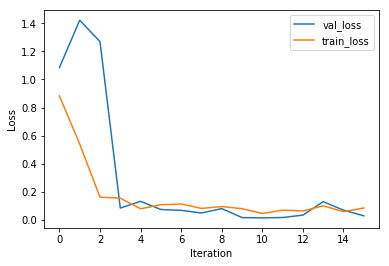

In [30]:
# Plot the performance of the model
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='train_loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Iteration');

In [9]:
%%time
test_generator = test_datagen.flow_from_directory('Validation Images',
                                                  target_size=(299,299),
                                                  color_mode='rgb',
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  shuffle=False)

best_model = load_model('best_model.hdf5')
y_true = test_generator.classes
y_pred = best_model.predict_generator(generator=test_generator, verbose=1)
y_hat = y_pred > 0.5
print("Accuracy:", accuracy_score(y_true, y_hat))
print("F1-Score:", f1_score(y_true, y_hat))
print("Classification Report:\n", classification_report(y_true, y_hat))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_hat))

Found 3599 images belonging to 2 classes.
180/180 [==============================] - 127s 704ms/step
Accuracy: 0.9974993053626007
F1-Score: 0.9975006942515968
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1794
           1       1.00      1.00      1.00      1805

    accuracy                           1.00      3599
   macro avg       1.00      1.00      1.00      3599
weighted avg       1.00      1.00      1.00      3599

Confusion Matrix:
 [[1794    0]
 [   9 1796]]
CPU times: user 47.9 s, sys: 7.92 s, total: 55.9 s
Wall time: 2min 15s


In [145]:
data_test = pd.read_csv('test.csv')
print(data_test.shape)
data_test.head()

(7534, 2)


,Image_File,Class
0,lg 988 (1).png,NaN
1,lg 988 (10).png,NaN
2,lg 988 (100).png,NaN
3,lg 988 (101).png,NaN
4,lg 988 (102).png,NaN


In [0]:
%%time

y_pred = []; i = 0; batch = 8;
for _ in tqdm(range(round(data_test.shape[0]/batch) + 1)):
    images = []
    for file in data_test['Image_File'][i:i+batch]:
        # print(file)
        image = load_img(os.path.join('Test Images', file), target_size=(299, 299))
        image = img_to_array(image)
        image *= 1./255
        images.append(image)
    y_pred.append(best_model.predict([images], batch_size=batch))
    i += batch
    if i > data_test.shape[0]:
        break

y_hat = []
for batch in y_pred:
    for x in batch:
        val = x[0]
        if val >= 0.5:
            y_hat.append('Small')
        else:
            y_hat.append('Large')

In [169]:
data_test['Class'] = y_hat
data_test.head()

,Image_File,Class
0,lg 988 (1).png,Small
1,lg 988 (10).png,Small
2,lg 988 (100).png,Small
3,lg 988 (101).png,Small
4,lg 988 (102).png,Small


In [0]:
data_test.to_csv('Submission_1.csv', index=False)